In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import pickle
import torch.nn as nn
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
cd /home/whut4/liyafei/newtype

/home/whut4/liyafei/newtype


In [3]:
def visualize_vector_distribution(source1, source2, target):
    # 将四个PyTorch Tensor转换为NumPy数组
    array1_np = source1
    array2_np = source2
    array3_np = target

    # 将四个数组合并为一个大数组
    combined_array = np.concatenate((array1_np, array2_np, array3_np), axis=0)

    # 将数组展平为2D矩阵（行表示向量，列表示特征）
    flattened_array = combined_array.reshape(combined_array.shape[0], -1)

    # 使用PCA将向量降至三维
    pca = PCA(n_components=3)
    reduced_array = pca.fit_transform(flattened_array)

    # 分离降维后的数组
    reduced_array1 = reduced_array[:array1_np.shape[0]]
    reduced_array2 = reduced_array[array1_np.shape[0]:array1_np.shape[0] + array2_np.shape[0]]
    reduced_array3 = reduced_array[
                     array1_np.shape[0] + array2_np.shape[0]:array1_np.shape[0] + array2_np.shape[0] + array3_np.shape[
                         0]]

    # 绘制三维散点图
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')

    #---
    ax.grid(True)
    ax.xaxis.pane.fill = False  # X-axis
    ax.yaxis.pane.fill = False  # Y-axis
    ax.zaxis.pane.fill = False  # Z-axis

    # Set edge color to black to improve axis visibility
    ax.xaxis.pane.set_edgecolor('black')
    ax.yaxis.pane.set_edgecolor('black')
    ax.zaxis.pane.set_edgecolor('black')

    #---

    ax.scatter(reduced_array1[:, 0], reduced_array1[:, 1], reduced_array1[:, 2], c='red', label='Source 1')
    ax.scatter(reduced_array2[:, 0], reduced_array2[:, 1], reduced_array2[:, 2], c='blue', label='Source 2')
    ax.scatter(reduced_array3[:, 0], reduced_array3[:, 1], reduced_array3[:, 2], c='green', label='Target')


    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    ax.legend(loc='upper right', fontsize='xx-large')
    plt.show()

In [4]:
def concatenate_arrays2(arr):
    num_arrays = len(arr) // 20  # 计算可以拼接的数组组数
    concatenated = []

    for i in range(num_arrays):
        start_index = i * 20  # 计算每组开始的索引
        end_index = start_index + 20  # 计算每组结束的索引
        concat_array = np.concatenate(arr[start_index:end_index], axis=0)
        reshaped_array = concat_array.reshape((20, 384))  # 重新调整数组的形状
        concatenated.append(reshaped_array)

    return np.stack(concatenated)

In [5]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size = 384, hidden_size = 500, num_layers = 2, num_classes=2, dropout=0.3):
        super(LSTMClassifier, self).__init__()

        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True,
                            dropout=dropout,
                            bidirectional=True)

        # Considering bidirectional LSTM, hence multiplying by 2 for the final layer output size
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        # Passing the input sequence through LSTM layers
        lstm_out, _ = self.lstm(x)

        # For feature extraction, we will use the last output of the sequence before classification
        features = lstm_out[:, -1, :]
        out = self.fc(features)

        return out, features  # return both output and features

In [6]:
def get_mid_feature(D_logs, model):
    model.eval()
    dataset_D1 = []
    for data in D_logs:
        data = torch.tensor(data).to(device)
        data = data.unsqueeze(0)

        _, data = model(data)

        data = data[0].detach()

        dataset_D1.append(data)
    dataset_D1 = torch.stack(dataset_D1)
    return dataset_D1

In [7]:
D1 = 'BGL'
D2 = 'Spirit'
D3 = 'TB'

logNum = 1000
with open("{}/{}_normal.pickle".format(D1, D1), "rb") as f:
    D1_normal_logs = pickle.load(f)
with open("{}/{}_abnormal.pickle".format(D1, D1), "rb") as f:
    D1_abnormal_logs = pickle.load(f)
with open("{}/{}_normal.pickle".format(D2, D2), "rb") as f:
    D2_normal_logs = pickle.load(f)
with open("{}/{}_abnormal.pickle".format(D2, D2), "rb") as f:
    D2_abnormal_logs = pickle.load(f)
with open("{}/{}_normal.pickle".format(D3, D3), "rb") as f:
    D3_normal_logs = pickle.load(f)
with open("{}/{}_abnormal.pickle".format(D3, D3), "rb") as f:
    D3_abnormal_logs = pickle.load(f)

num = 20 * 1000
num2 = 2 * num

D1_normal_logs = D1_normal_logs[:num]
D1_abnormal_logs = D1_abnormal_logs[:num]
D2_normal_logs = D2_normal_logs[:num]
D2_abnormal_logs = D2_abnormal_logs[:num]
D3_normal_logs = D3_normal_logs[:num]
D3_abnormal_logs = D3_abnormal_logs[:num]
D1_normal_logs = concatenate_arrays2(D1_normal_logs)
D1_abnormal_logs = concatenate_arrays2(D1_abnormal_logs)
D2_normal_logs = concatenate_arrays2(D2_normal_logs)
D2_abnormal_logs = concatenate_arrays2(D2_abnormal_logs)
D3_normal_logs = concatenate_arrays2(D3_normal_logs)
D3_abnormal_logs = concatenate_arrays2(D3_abnormal_logs)

D1 = np.vstack((D1_normal_logs, D1_abnormal_logs))
D2 = np.vstack((D2_normal_logs, D2_abnormal_logs))
D3 = np.vstack((D3_normal_logs, D3_abnormal_logs))

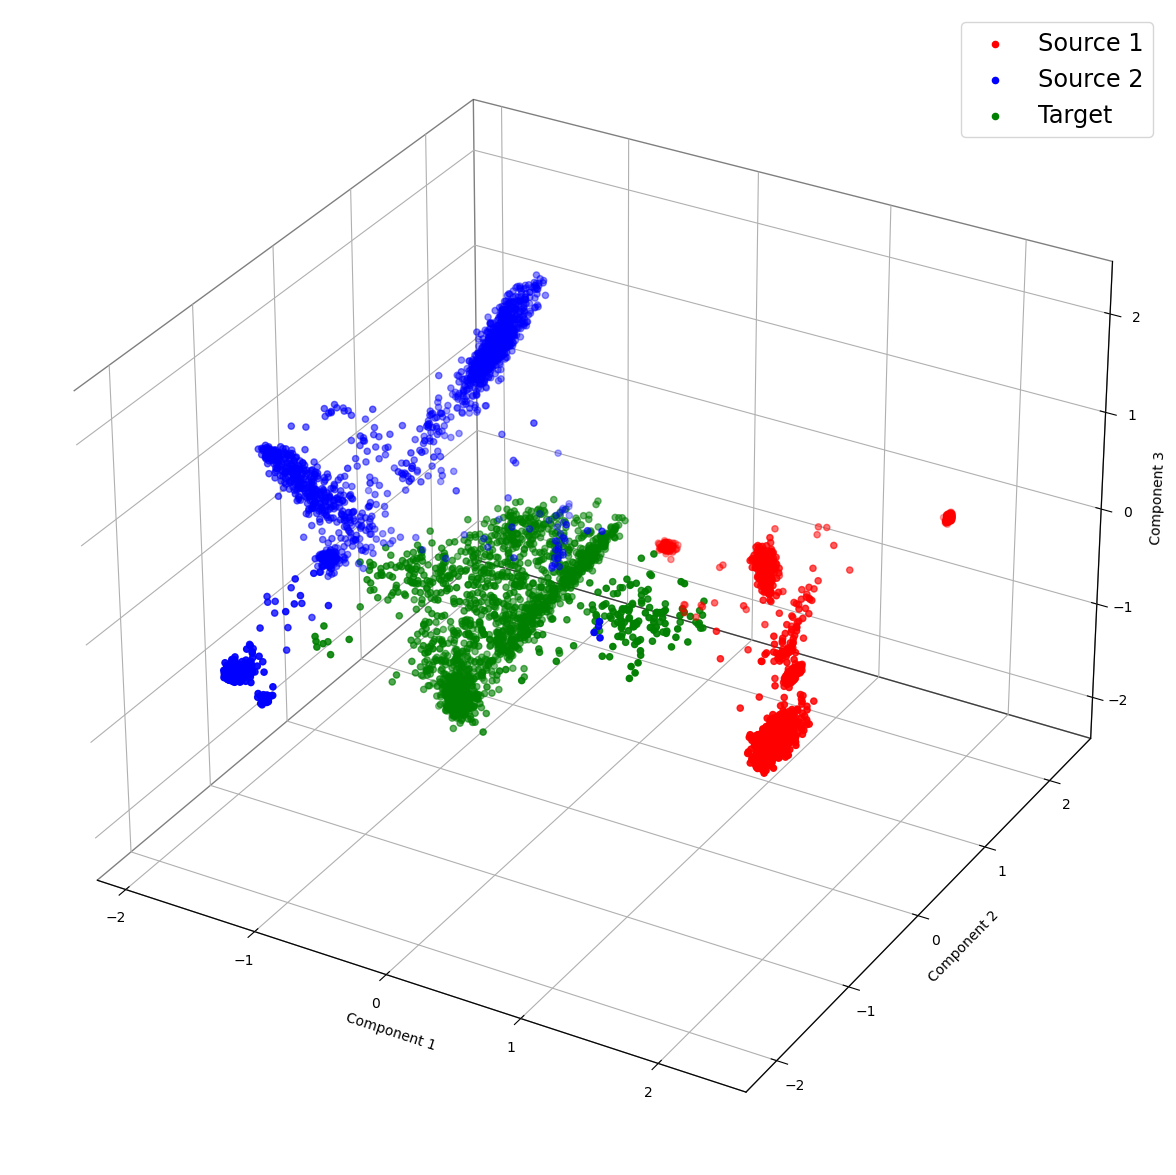

In [8]:
visualize_vector_distribution(D1, D2, D3)

In [12]:
model = LSTMClassifier().to(device)
model.load_state_dict(torch.load(f'/home/whut4/liyafei/newtype/BGL->TB_cdd.pth'))

<All keys matched successfully>

In [13]:
D1f = get_mid_feature(D1, model).cpu()
D2f = get_mid_feature(D2, model).cpu()
D3f = get_mid_feature(D3, model).cpu()

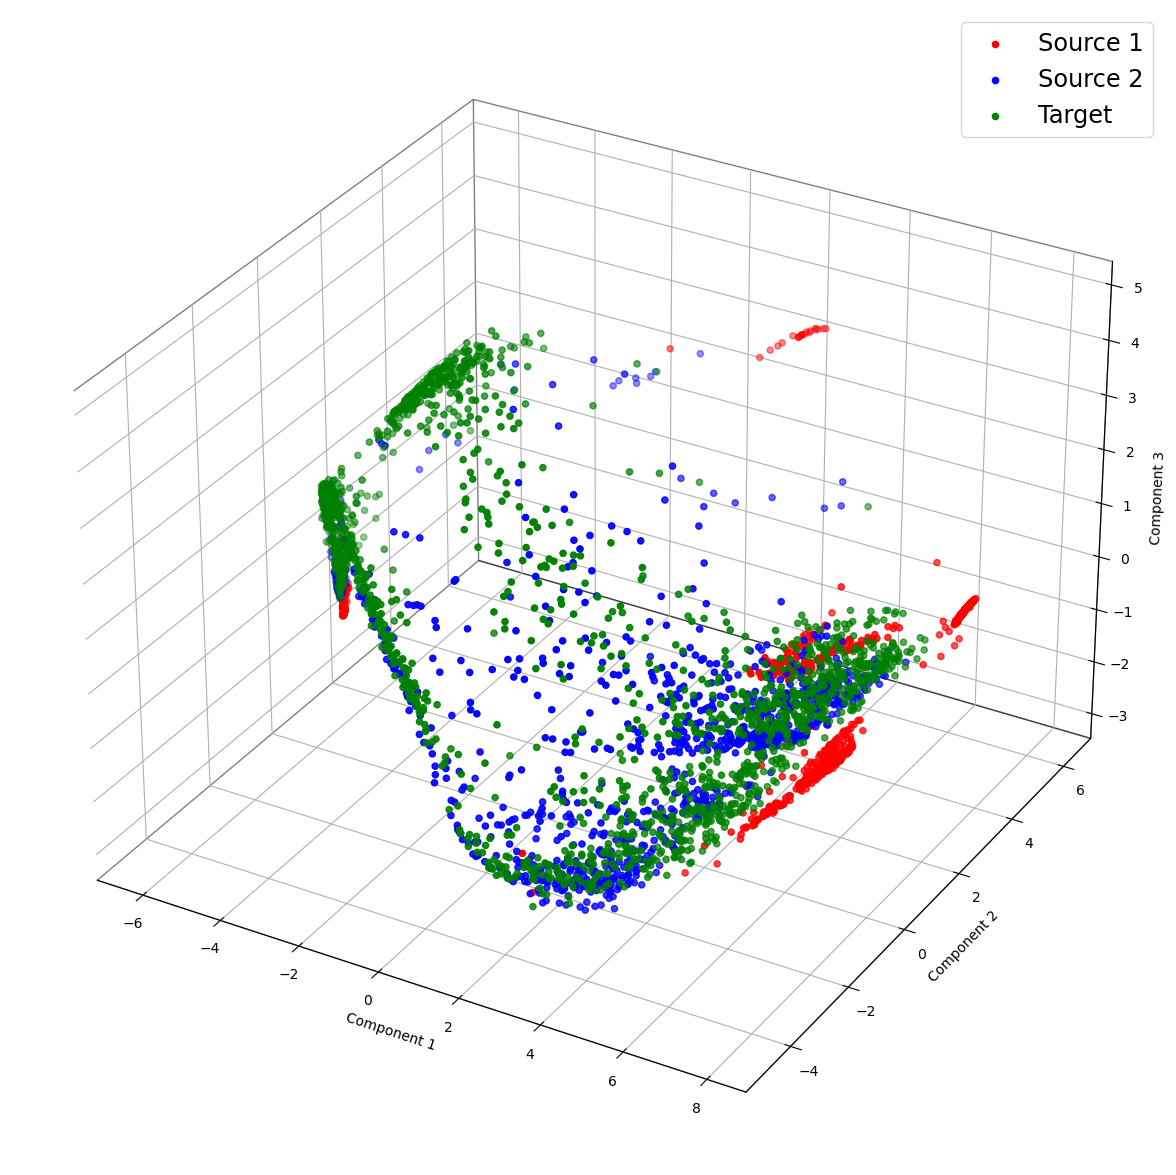

In [14]:
visualize_vector_distribution(D1f, D2f, D3f)